### Import libraries

In [1]:
import pandas as pd
from numpy import arange
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer, recall_score
from constants import target_col as target_name, index_col as index_name, dt_algo, rf_algo, \
lr_algo, svm_algo, report_cmap, seed
from utilities import do_modeling, get_evaluation_report, invert_label, plot_column_values

### Configure defaults

In [2]:
prediction_column = 'prediction'
classes = ['Not churn', 'Churn']

index_col = index_name.lower()
target_col = [target_name]

plt.style.use('fivethirtyeight')

### Read data

In [3]:
train_std = pd.read_csv('./outputs/std/train.csv').set_index(index_col)
test_std = pd.read_csv('./outputs/std/test.csv').set_index(index_col)

train_mm = pd.read_csv('./outputs/min_max/train.csv').set_index(index_col)
test_mm = pd.read_csv('./outputs/min_max/test.csv').set_index(index_col)

### Data check

In [4]:
train_std.head()

,attrition_flag,gender_F,gender_M,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
clientnum,,,,,,,,,,,,,,,,
713796033,1,0,1,0.085971,-0.271041,0.761682,1.409797,0.661411,0.498335,-0.427523,-1.423834,-0.541924,-0.736571,-1.228105,-0.892927,-0.997729
771204108,0,1,0,-1.290336,-0.271041,-1.623249,-0.527633,-1.331855,-2.214038,-0.734047,0.023954,0.489055,-0.149068,0.092368,0.025604,1.201739
721399833,0,1,0,-0.414504,-0.271041,-0.242499,-0.527633,-1.331855,0.498335,-0.725459,-0.186031,0.543798,0.098177,0.901690,0.497510,0.811452
778601733,1,1,0,1.086921,0.499385,1.389296,0.763987,1.658044,0.498335,-0.653342,0.650224,-0.208908,-0.598231,-1.313297,0.324759,1.296575
714047733,0,1,0,0.836684,0.499385,1.138250,-1.173443,-0.335222,-1.309914,-0.405063,1.178255,-0.190661,0.899960,0.859094,-0.454728,0.567066


In [5]:
train_mm.head()

,attrition_flag,gender_F,gender_M,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
clientnum,,,,,,,,,,,,,,,,
713796033,1,0,1,0.446809,0.4,0.674419,1.0,0.500000,0.500000,0.099756,0.000000,0.188696,0.076306,0.201550,0.140017,0.000000
771204108,0,1,0,0.212766,0.4,0.232558,0.4,0.166667,0.000000,0.015591,0.468415,0.255225,0.187479,0.441860,0.201064,0.603604
721399833,0,1,0,0.361702,0.4,0.488372,0.4,0.166667,0.500000,0.017949,0.400477,0.258758,0.234265,0.589147,0.232428,0.496496
778601733,1,1,0,0.617021,0.6,0.790698,0.8,0.666667,0.500000,0.037751,0.671037,0.210185,0.102484,0.186047,0.220947,0.629630
714047733,0,1,0,0.574468,0.6,0.744186,0.2,0.333333,0.166667,0.105923,0.841875,0.211363,0.385986,0.581395,0.169140,0.429429


In [6]:
print('Standardized train set shape:', train_std.shape, 'test set shape:', test_std.shape)
print('MinMax scaled train set shape:', train_mm.shape, 'test set shape:', test_mm.shape)

Standardized train set shape: (8607, 16) test set shape: (1520, 16)
MinMax scaled train set shape: (8607, 16) test set shape: (1520, 16)


In [7]:
print('NA count by column and dataset')

NA_df = pd.DataFrame()
NA_df['train_standardized'] = train_std.isna().sum()
NA_df['test_standardized'] = test_std.isna().sum()
NA_df['train_minmax'] = train_mm.isna().sum()
NA_df['test_minmax'] = test_mm.isna().sum()
NA_df.T

NA count by column and dataset


,attrition_flag,gender_F,gender_M,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
train_standardized,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
test_standardized,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
train_minmax,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
test_minmax,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Separate target

In [8]:
X_train_std, y_train_std = train_std.drop(columns=target_col), train_std[target_name]
X_test_std, y_test_std = test_std.drop(columns=target_col), test_std[target_name]

X_train_mm, y_train_mm = train_mm.drop(columns=target_col), train_mm[target_name]
X_test_mm, y_test_mm = test_mm.drop(columns=target_col), test_mm[target_name]

### Modeling

In [9]:
std_models = do_modeling(X_train_std, y_train_std)
mm_models = do_modeling(X_train_mm, y_train_mm)

In [10]:
std_models, mm_models

({'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
  'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
  'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
  'Support Vector Machine': SVC(class_weight='balanced', random_state=42)},
 {'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
  'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
  'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
  'Support Vector Machine': SVC(class_weight='balanced', random_state=42)})

### Evaluation

In [11]:
std_eval_report = get_evaluation_report(std_models, X_test_std, y_test_std)
mm_eval_report = get_evaluation_report(mm_models, X_test_mm, y_test_mm)

In [12]:
std_eval_report.style.background_gradient(cmap=report_cmap)

,algorithm,class,precision,recall,f1,support
0,Decision Tree,0,0.971383,0.957680,0.964483,1276
1,Decision Tree,1,0.793893,0.852459,0.822134,244
2,Random Forest,0,0.968364,0.983542,0.975894,1276
3,Random Forest,1,0.906250,0.831967,0.867521,244
4,Logistic Regression,0,0.963866,0.836207,0.895510,1276
5,Logistic Regression,1,0.493947,0.836066,0.621005,244
6,Support Vector Machine,0,0.983939,0.912226,0.946726,1276
7,Support Vector Machine,1,0.667656,0.922131,0.774527,244


In [13]:
mm_eval_report.style.background_gradient(cmap=report_cmap)

,algorithm,class,precision,recall,f1,support
0,Decision Tree,0,0.971406,0.958464,0.964892,1276
1,Decision Tree,1,0.796935,0.852459,0.823762,244
2,Random Forest,0,0.968364,0.983542,0.975894,1276
3,Random Forest,1,0.906250,0.831967,0.867521,244
4,Logistic Regression,0,0.964674,0.834639,0.894958,1276
5,Logistic Regression,1,0.492788,0.840164,0.621212,244
6,Support Vector Machine,0,0.981132,0.896552,0.936937,1276
7,Support Vector Machine,1,0.627119,0.909836,0.742475,244


### Visualization

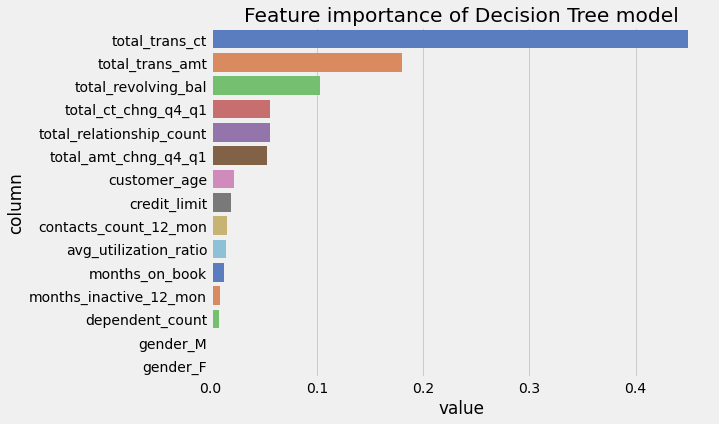

In [14]:
plot_column_values(
    mm_models.get(dt_algo).feature_importances_,
    X_test_mm.columns,
    'Feature importance of {} model'.format(dt_algo)
)

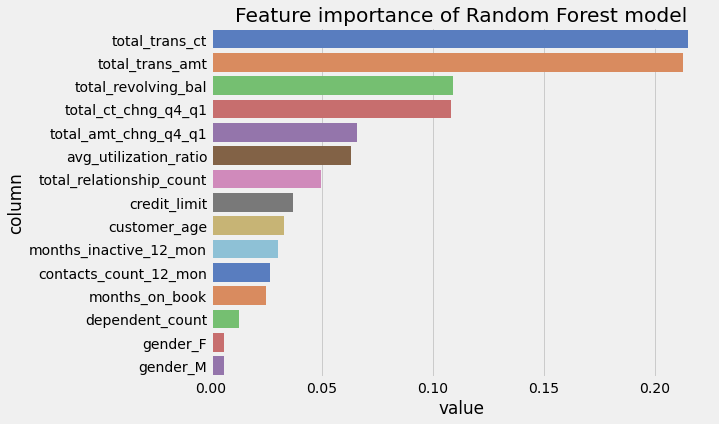

In [15]:
plot_column_values(
    mm_models.get(rf_algo).feature_importances_,
    X_test_mm.columns,
    'Feature importance of {} model'.format(rf_algo)
)

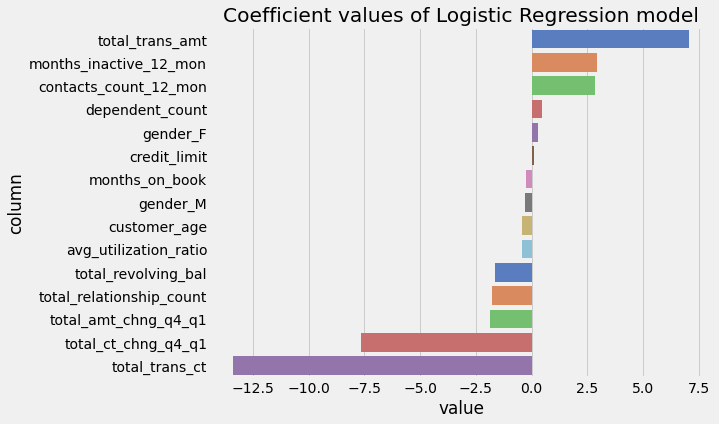

In [16]:
plot_column_values(
    mm_models.get(lr_algo).coef_[0],
    X_test_mm.columns,
    'Coefficient values of {} model'.format(lr_algo)
)

### Tuning

In [17]:
params = dict(
    C=10 ** arange(-4, 2.5, 0.5)
)

scorer = make_scorer(recall_score, average='binary')

clf = RandomizedSearchCV(
    SVC(class_weight='balanced', random_state=seed),
    params,
    random_state=seed,
    cv=5,
    n_jobs=-1,
    scoring=scorer,
    n_iter=13
)

In [18]:
fitted = clf.fit(X_train_std, y_train_std)

In [19]:
fitted.best_estimator_

SVC(C=0.31622776601683794, class_weight='balanced', random_state=42)

### Evaluation

In [20]:
preds = fitted.best_estimator_.predict(X_test_std)
print(classification_report(y_test_std, preds))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1276
           1       0.63      0.90      0.74       244

    accuracy                           0.90      1520
   macro avg       0.80      0.90      0.84      1520
weighted avg       0.92      0.90      0.90      1520



### Prediction

In [21]:
X_test_std[prediction_column] = preds

In [22]:
pd.concat([X_test_std[prediction_column], y_test_std], axis=1).sample(15)

,prediction,attrition_flag
clientnum,,
709546608,0,0
713717283,1,1
710262408,0,0
813182658,0,0
715357308,0,0
718797558,0,0
719071158,1,1
708205083,0,0
710850633,0,0
